In [3]:
# Paths (adjust as needed)
PARQUET_PATH = "../data/ncc_2t_timeseries_2010_2039.parquet"
HOMES_GEOJSON = "../data/ncc_neighborhood_10k.geojson"   # your building polygons

# Libs
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

pd.options.display.max_rows = 8


In [10]:
# Load only what we need and sort so we can reshape cleanly
clim = (
    pd.read_parquet(PARQUET_PATH, engine="pyarrow")
      [["timestamp","latitude","longitude","temp_C"]]
      .sort_values(["timestamp", "latitude", "longitude"], kind="mergesort")
      .reset_index(drop=True)
)

# exact duplicates?
dupes = clim.duplicated(["timestamp","latitude","longitude"]).sum()
print("Exact duplicate rows:", dupes)

# how many rows should each timestamp have?
per_ts = clim.groupby("timestamp").size()
print("Min/Median/Max rows per timestamp:", per_ts.min(), per_ts.median(), per_ts.max())

# 1) Drop exact duplicate rows
clim = clim.drop_duplicates(["timestamp", "latitude", "longitude"], keep="first")

# 2) Recompute T and confirm
times = clim["timestamp"].drop_duplicates().to_numpy()
points_df = clim[["latitude","longitude"]].drop_duplicates().reset_index(drop=True)
P = len(points_df)
T = len(times)

print("After dedup → rows:", len(clim), "timestamps:", T, "points:", P)

# 3) Sort for reshape
clim = clim.sort_values(["timestamp","latitude","longitude"], kind="mergesort").reset_index(drop=True)

assert len(clim) == T * P, (len(clim), T, P)

# 4) Build arrays
temps = clim["temp_C"].to_numpy(dtype=np.float32).reshape(T, P)
points = points_df.to_numpy(dtype=np.float32)


T, P, times[:3], points_df.head()


Exact duplicate rows: 9120
Min/Median/Max rows per timestamp: 20 20.0 40
After dedup → rows: 3506400 timestamps: 175320 points: 20


(175320,
 20,
 array([Timestamp('2020-01-01 00:00:00+0000', tz='UTC'),
        Timestamp('2020-01-01 01:00:00+0000', tz='UTC'),
        Timestamp('2020-01-01 02:00:00+0000', tz='UTC')], dtype=object),
     latitude  longitude
 0  54.916332  -1.726190
 1  54.916332  -1.607143
 2  54.916332  -1.488095
 3  54.916332  -1.369048
 4  54.964245  -1.728477)

/var/folders/rz/68rzz4790djdsk13ycd911f00000gr/T/ipykernel_25403/3162882615.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_q["quarter"] = df_q["timestamp"].dt.to_period("Q")


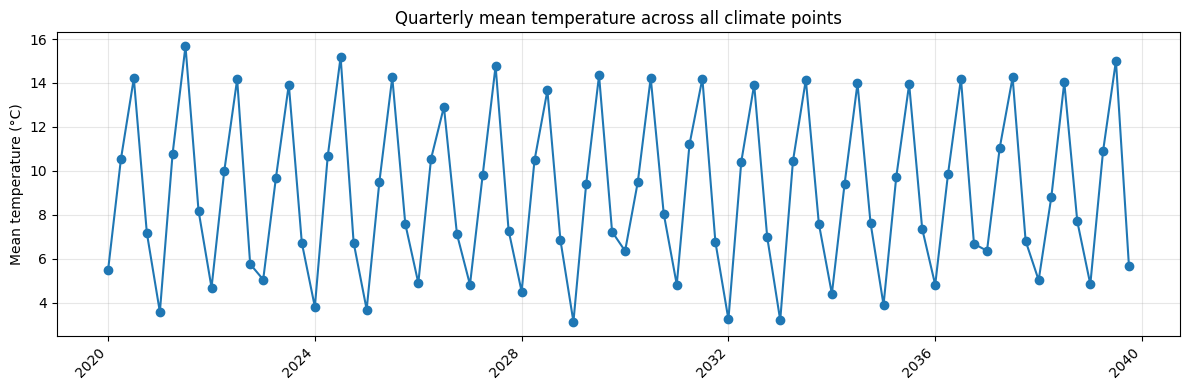

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# `times` is your numpy datetime64 array of shape [T]
# `temps` is your float32 array of shape [T, P]

# 1) average across all climate points for each timestamp
mean_all_pts = temps.mean(axis=1)  # shape [T]

# 2) build DataFrame with quarters
df_q = pd.DataFrame({
    "timestamp": pd.to_datetime(times),
    "tempC": mean_all_pts,
})
df_q["quarter"] = df_q["timestamp"].dt.to_period("Q")

# 3) aggregate quarterly mean
quarterly = df_q.groupby("quarter")["tempC"].mean().reset_index()
quarterly["quarter"] = quarterly["quarter"].dt.to_timestamp()  # for plotting on x-axis

# 4) plot
plt.figure(figsize=(12,4))
plt.plot(quarterly["quarter"], quarterly["tempC"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean temperature (°C)")
plt.title("Quarterly mean temperature across all climate points")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
# Load homes polygons; use centroids for location
homes = gpd.read_file(HOMES_GEOJSON)
assert "geometry" in homes.columns

homes = homes.copy()
homes["centroid"] = homes.geometry.buffer(0).centroid
homes["lat"] = homes["centroid"].y.astype(np.float32)
homes["lon"] = homes["centroid"].x.astype(np.float32)

# KDTree on climate points
tree = cKDTree(points[:, [0,1]])  # (lat, lon)
dist, idx = tree.query(np.c_[homes["lat"], homes["lon"]], k=1)

homes["clim_idx"] = idx.astype(np.int32)
homes["clim_dist_km"] = (dist * 111.0).astype(np.float32)   # rough deg→km at mid-lat
homes[["fid","lat","lon","clim_idx","clim_dist_km"]].head()


/var/folders/rz/68rzz4790djdsk13ycd911f00000gr/T/ipykernel_25403/165456557.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  homes["centroid"] = homes.geometry.buffer(0).centroid


,fid,lat,lon,clim_idx,clim_dist_km
0,osgb1000030010159,54.985348,-1.652327,5,5.322345
1,osgb1000030010437,54.986801,-1.652124,9,5.323713
2,osgb1000030012569,54.990772,-1.653636,9,5.253785
3,osgb1000030012569,54.990772,-1.653636,9,5.253785
4,osgb1000030012637,54.988472,-1.652455,9,5.259889


In [13]:
N = len(homes)
print("Homes:", N, "  Climate points:", P)

# every home got an index
assert homes["clim_idx"].notna().all()

# basic stats on distance
print(homes["clim_dist_km"].describe())

# how many homes per climate point (load balance)
per_point = homes["clim_idx"].value_counts().sort_index()
per_point.describe()


Homes: 91947   Climate points: 20
count    91947.000000
mean         3.866995
std          1.675680
min          0.007313
25%          2.562552
50%          3.785066
75%          5.315277
max          7.025500
Name: clim_dist_km, dtype: float64


count        6.000000
mean     15324.500000
std      14686.295799
min        766.000000
25%       4387.000000
50%      13779.500000
75%      19686.000000
max      40711.000000
Name: count, dtype: float64

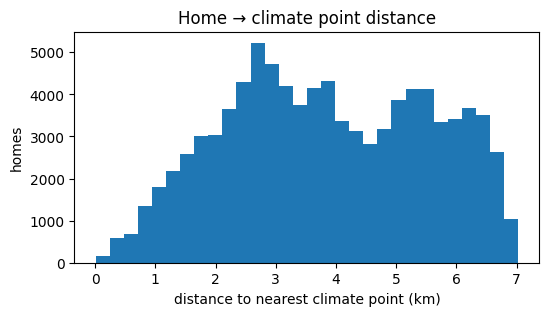

In [14]:
plt.figure(figsize=(6,3))
plt.hist(homes["clim_dist_km"], bins=30)
plt.xlabel("distance to nearest climate point (km)")
plt.ylabel("homes")
plt.title("Home → climate point distance")
plt.show()


In [15]:
# Make times tz-naive UTC
times_naive = pd.to_datetime(times, utc=True).tz_convert(None).to_numpy("datetime64[ns]")
print(times_naive)
# Naive UTC start
SIM_START = np.datetime64("2020-01-01T00:00:00")  # no 'Z'

t0 = int(np.searchsorted(times_naive, SIM_START))
if t0 >= len(times_naive):
    raise ValueError(f"SIM_START {SIM_START} is beyond available data (max {times_naive[-1]})")
if times_naive[t0] != SIM_START:
    print(f"⚠️ Requested {SIM_START} not found; using next available {times_naive[t0]}")

['2020-01-01T00:00:00.000000000' '2020-01-01T01:00:00.000000000'
 '2020-01-01T02:00:00.000000000' ... '2039-12-31T21:00:00.000000000'
 '2039-12-31T22:00:00.000000000' '2039-12-31T23:00:00.000000000']


In [16]:
# Build a DataFrame of per-time per-home temperature using vectorized gather, chunked to save RAM
home_idx = homes["clim_idx"].to_numpy()
quarters = pd.PeriodIndex(pd.to_datetime(times), freq="Q")

# Group-by quarter using point-level first (faster than exploding to homes immediately)
# 1) mean temp per climate point per quarter
df_point = (
    pd.DataFrame({
        "timestamp": pd.to_datetime(times),
        "quarter": quarters.astype(str)
    })
)

# For memory efficiency, we'll compute by quarter in a loop:
point_q_means = {}  # key: quarter str -> np.array shape [P]
for q in df_point["quarter"].unique():
    mask = (df_point["quarter"].values == q)
    # mean along time axis for this quarter => shape [P]
    point_q_means[q] = temps[mask, :].mean(axis=0)

# 2) map point quarterly means → homes
home_q_rows = []
for q, vecP in point_q_means.items():
    # gather per-home temps
    th = vecP[home_idx]  # shape [N homes]
    home_q_rows.append(pd.DataFrame({"quarter": q, "fid": homes["fid"].values, "tempC_mean": th}))

home_quarter = pd.concat(home_q_rows, ignore_index=True)

home_quarter.head(), home_quarter["quarter"].nunique(), len(home_quarter)


(  quarter                fid  tempC_mean
 0  2020Q1  osgb1000030010159    5.218742
 1  2020Q1  osgb1000030010437    5.184785
 2  2020Q1  osgb1000030012569    5.184785
 3  2020Q1  osgb1000030012569    5.184785
 4  2020Q1  osgb1000030012637    5.184785,
 80,
 7355760)

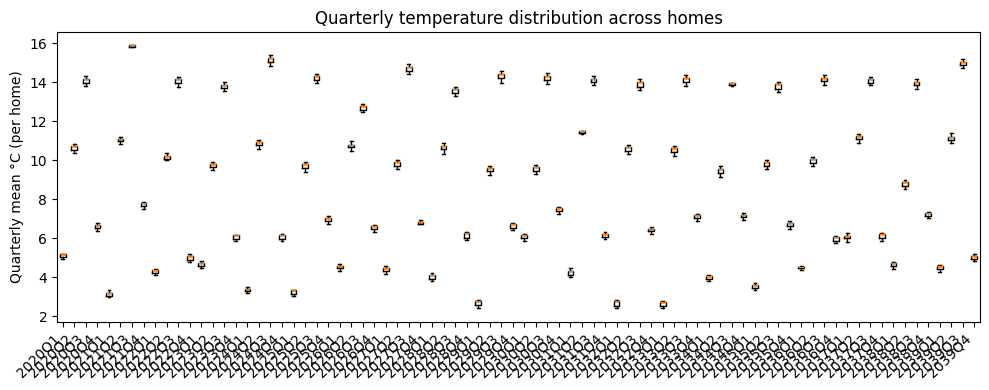

In [17]:
# ensure chronological quarter order
home_quarter["q_order"] = pd.PeriodIndex(home_quarter["quarter"], freq="Q").astype(int)
home_quarter = home_quarter.sort_values(["q_order","fid"])

plt.figure(figsize=(10,4))
# Draw a boxplot per quarter
grouped = [g["tempC_mean"].values for _, g in home_quarter.groupby("quarter")]
plt.boxplot(grouped, showfliers=False)
plt.xticks(range(1, len(grouped)+1), list(home_quarter["quarter"].unique()), rotation=45, ha="right")
plt.ylabel("Quarterly mean °C (per home)")
plt.title("Quarterly temperature distribution across homes")
plt.tight_layout()
plt.show()


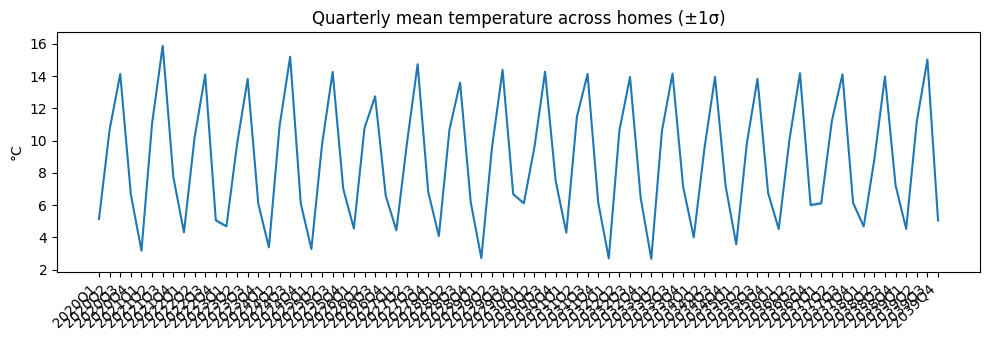

In [ ]:
agg = (home_quarter
       .groupby("quarter")["tempC_mean"]
       .agg(["mean","std"])
       .reset_index())
agg["q_order"] = pd.PeriodIndex(agg["quarter"], freq="Q").astype(int)
agg = agg.sort_values("q_order")

plt.figure(figsize=(10,3.5))
plt.plot(agg["quarter"], agg["mean"])
# (no colors per matplotlib rule-of-thumb; this keeps defaults)
plt.fill_between(agg["quarter"], agg["mean"]-agg["std"], agg["mean"]+agg["std"], alpha=0.2)
plt.xticks(rotation=45, ha="right")
plt.ylabel("°C")
plt.title("Quarterly mean temperature across homes (±1)")
plt.tight_layout()
plt.show()


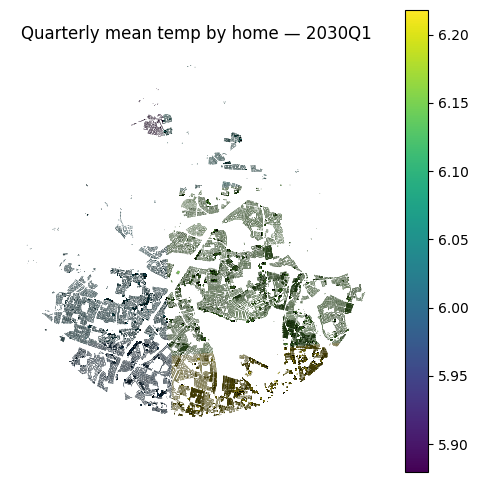

In [19]:
Q_PICK = agg["quarter"].iloc[len(agg)//2]  # middle quarter as example
gmap = homes.merge(home_quarter[home_quarter["quarter"]==Q_PICK][["fid","tempC_mean"]], on="fid", how="left")

ax = gmap.plot(column="tempC_mean", legend=True, figsize=(6,6), linewidth=0.1, edgecolor="black")
ax.set_title(f"Quarterly mean temp by home — {Q_PICK}")
ax.set_axis_off()
plt.show()


In [35]:
homes_pts = homes.to_crs(27700).copy()

homes_pts["geometry"] = homes_pts.geometry.centroid  # guard invalids
homes_pts = homes_pts.to_crs(4326)[["fid","geometry"]].copy()
homes_pts

,fid,geometry
0,osgb1000030010159,POINT (-1.65233 54.98535)
1,osgb1000030010437,POINT (-1.65212 54.9868)
2,osgb1000030012569,POINT (-1.65364 54.99077)
3,osgb1000030012569,POINT (-1.65364 54.99077)
...,...,...
91943,osgb1000030080692,POINT (-1.61916 54.97532)
91944,osgb1000030080692,POINT (-1.61916 54.97532)
91945,osgb1000030080692,POINT (-1.61916 54.97532)
91946,osgb1000030080692,POINT (-1.61916 54.97532)


In [40]:
from ipywidgets import Dropdown, VBox, Output
from IPython.display import display, clear_output
import folium
from folium.plugins import HeatMap
import numpy as np
import pandas as pd
import geopandas as gpd
import branca.colormap as cm

# --- 1) Annual mean temperature per home (same logic as before) ---
hq = home_quarter.copy()
hq["year"] = pd.PeriodIndex(hq["quarter"], freq="Q").year
home_annual = (hq.groupby(["fid","year"])["tempC_mean"]
                 .mean()
                 .reset_index()
                 .rename(columns={"tempC_mean":"tempC_annual"}))

if home_annual.empty:
    raise ValueError("No annual data found.")

# --- 2) Represent each home as a point (centroid), WGS84 for Leaflet ---
# Use a projected CRS for accurate centroids, then convert to 4326
homes_pts = homes.to_crs(27700).copy()
homes_pts["geometry"] = homes_pts.geometry.centroid  # guard invalids
homes_pts = homes_pts.to_crs(4326)[["fid","geometry"]].copy()

# Precompute lat/lon for speed (drop any invalid/missing)
homes_pts["lat"] = homes_pts.geometry.y
homes_pts["lon"] = homes_pts.geometry.x
homes_pts = homes_pts.dropna(subset=["lat","lon"])

# --- 3) Build year lookup & global min/max for legend/normalization ---
years = sorted(home_annual["year"].dropna().unique().astype(int).tolist())
if not years:
    raise ValueError("No annual years found.")

merged_all = homes_pts.merge(home_annual, on="fid", how="left")
vmin = float(merged_all["tempC_annual"].min())
vmax = float(merged_all["tempC_annual"].max())
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
    vmin, vmax = (0.0, 20.0)

# Colormap for legend (HeatMap uses its own gradient; legend shows °C scale)
colormap = cm.linear.viridis.scale(vmin, vmax)
colormap.caption = "Annual mean temperature (°C)"

def _make_heat_data(dfy):
    w = (dfy["tempC_annual"] - vmin) / (vmax - vmin)
    w = w.clip(lower=0, upper=1).fillna(0)
    return dfy.assign(weight=w)[["lat","lon","weight"]].values.tolist()

def make_map(year: int):
    dfy = homes_pts.merge(
        home_annual[home_annual["year"] == year][["fid","tempC_annual"]],
        on="fid", how="left"
    ).dropna(subset=["tempC_annual"])
    if dfy.empty:
        raise ValueError(f"No data for year {year}.")
    center = [float(dfy["lat"].mean()), float(dfy["lon"].mean())]
    fmap = folium.Map(location=center, zoom_start=11, tiles="CartoDB positron")
    HeatMap(_make_heat_data(dfy), radius=16, blur=12, max_zoom=18, min_opacity=0.3).add_to(fmap)
    # optional tiny markers with tooltips
    for r in dfy.itertuples(index=False):
        folium.CircleMarker([r.lat, r.lon], radius=2, weight=0, fill=True, fill_opacity=0.8)\
              .add_child(folium.Tooltip(f"{r.tempC_annual:.2f} °C")).add_to(fmap)
    fmap.add_child(colormap)
    return fmap

year_dd = Dropdown(options=years, value=years[0], description="Year")
out = Output()

def render(year):
    with out:
        clear_output(wait=True)
        display(make_map(year))

render(year_dd.value)

def _on_change(ch):
    if ch["name"] == "value":
        render(ch["new"])

year_dd.observe(_on_change, names="value")

display(VBox([year_dd, out]))